In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
import sys
import warnings
warnings.filterwarnings('ignore')

import time

from scipy.stats import ks_2samp


from astropy.table import Table

homedir = os.getenv("HOME")



In [11]:
from scipy.optimize import curve_fit
def gaussian(x,amplitude,center,sigma):
    return amplitude*(1/(sigma*(np.sqrt(2*np.pi))))*np.exp((-1.0/2.0)*((x-center)/sigma)**2)

def twogaussian(x_array, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen2)/sigma2)**2)))

def threegaussian(x_array, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen2)/sigma2)**2))) +\
            amp3*(1/(sigma3*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen3)/sigma3)**2)))

def gaussian1(x_array, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2))) 

def solve(m1,m2,std1,std2,amp1,amp2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1*amp1/amp2)
  return np.roots([a,b,c])

In [111]:
def separate_sf(x,y,m1=9,m2=10.8,ms_slope=0.56,ms_intercept=-5.74,dm=.15,nbins=20,twogauss=True,passive_cut=.848):

    lowmass=m1
    highmass=m2
    minmass = np.arange(lowmass,highmass,dm)
    maxmass = np.arange(lowmass+dm,highmass+dm,dm)

    histbins=np.linspace(-3,1,nbins)
    plt.figure(figsize=(12,10))
    plt.subplots_adjust(hspace=.5)
    nplot=1
    sfrcut_mass = []
    sfrcut_sfr = []
    lower_peak_sfr = []
    higher_peak_sfr = []
    higher_peak_std = []
    for m1,m2 in zip(minmass,maxmass):
        plt.subplot(4,4,nplot)
        flag = (x > m1) & (x < m2)
        # plot the data
        ybin,xbin_edge,t=plt.hist(y[flag],histtype='step',bins=histbins)
        xbin = (xbin_edge[:-1]+xbin_edge[1:])/2
        plt.title(r'$\rm {:.2f} < logMstar < {:.2f}$'.format(m1,m2),fontsize=14)
        

        xatmax= xbin[ybin == np.max(ybin)]
        xline=np.linspace(min(xbin),max(xbin),50)
        try:
            if twogauss:
                popt,pcov = curve_fit(twogaussian,xbin,ybin)
                yline = twogaussian(xline,*popt)
                plt.plot(xline,gaussian1(xline,popt[0],popt[1],popt[2]),'b')
                plt.plot(xline,gaussian(xline,popt[3],popt[4],popt[5]),'c-')
            else:
                popt,pcov = curve_fit(gaussian,xbin,ybin)
                yline = gaussian(xline,*popt)
                plt.plot(xline,gaussian1(xline,popt[0],popt[1],popt[2]),'b')
                #plt.plot(xline,gaussian(xline,popt[3],popt[4],popt[5]),'c-')
                #plt.plot(xline,gaussian(xline,popt[6],popt[7],popt[8]),'g-')
        except:
            continue
        # plot combined gaussian
        plt.plot(xline,yline,'r-')
        # plot the two gaussians individually
        
        # find intersection of two gaussians
        # solve(m1,m2,std1,std2)
        if twogauss:
            intersection = solve(popt[1],popt[4],popt[2],popt[5],popt[0],popt[3])
        
            # gaussians will likely have two points of intersection
            # use the minimum
            # if both are negative, then take the max
            if len(intersection) == 2:
                if (intersection[0] < 0) & (intersection[1] < 0):
                    sfr = np.max(intersection)
                else:
                    sfr = np.min(intersection)
        

                plt.axvline(x=sfr, ls='--',c='k')
                sfrcut_mass.append(0.5*(m1+m2))
                sfrcut_sfr.append(sfr)
           
            
                lower_peak_sfr.append(np.min([popt[1],popt[4]]))
                higher_peak_sfr.append(np.max([popt[1],popt[4]]))
                if popt[1] > popt[4]:
                    higher_peak_std.append(popt[2])
                else:
                    higher_peak_std.append(popt[5])
        else:
            sfrcut_mass.append(0.5*(m1+m2))
            higher_peak_sfr.append(popt[1])
            higher_peak_std.append(popt[2])
            
            #sfrcut_sfr.append(popt[1])
            #higher_peak_std.append(popt[2])
    
        plt.xlabel('SFR',fontsize=10)
        # add vertical line showing sSFR = -11.5
        sfr_limit = 0.5*(m1+m2) - 11.5
        plt.axvline(x=sfr_limit,ls=':')
        nplot += 1
    

    sfrcut_mass = np.array(sfrcut_mass)
    sfrcut_sfr = np.array(sfrcut_sfr)
    
   
    higher_peak_std = np.array(higher_peak_std)
    higher_peak_sfr = np.array(higher_peak_sfr)
  

    plt.figure()
    plt.plot(sfrcut_mass,higher_peak_sfr,'bo')
    # FIT MAIN SEQUENCE
    flag = (sfrcut_mass < 12) & (sfrcut_mass > 8)
    c,cov = np.polyfit(sfrcut_mass[flag],higher_peak_sfr[flag],2,cov=True)
    xline = np.linspace(lowmass,highmass,100)
    yline = np.polyval(c,xline)
    plt.plot(xline,yline,'r--')
    plt.xlabel('log Mass')
    plt.ylabel('Center of SF peak')
    print('SFR-Mstar best fit line : ',c)
    s = "sqrt of cov matrix = "
    for i in range(cov.shape[0]):
        s = s + ", {:.3e}".format(cov[i][i])
    print(s)
    
    # FILL BETWEEN +/- 1.5 SIGMA
    sigma=.3
    plt.fill_between(xline,yline+1.5*sigma,yline-1.5*sigma,label='+/-1.5 sigma',alpha=.2,color='r')

    # PLOT MS FIT - 0.67
    
    plt.plot(xline,yline-passive_cut,'c-',label='MS - {}'.format(passive_cut))
    # PLOT THE SSFR CUT FROM SALIM
    plt.plot(xline,xline-11.5,'k--',label='sSFR=-11.5')
    plt.legend()
   
    # plot std from the MS
    plt.figure()

    plt.plot(sfrcut_mass,higher_peak_std,'bo')
    plt.xlabel('log Mass')
    plt.ylabel('STD of MS')

    print('mean STD of MS = {:.2f}'.format(np.mean(higher_peak_std)))
    print('median STD of MS = {:.2f}'.format(np.median(higher_peak_std)))
    
    if twogauss:
         # plot intersection of two gaussians vs stellar mass
        plt.figure()
        plt.plot(sfrcut_mass,sfrcut_sfr,'bo')
        plt.xlabel('log Mass')
        plt.ylabel('SFR where gaussians intersect')
        print("average SFR of where gaussians overlap = {:.2f}".format(np.mean(sfrcut_sfr)))
        print("median SFR of where gaussians overlap = {:.2f}".format(np.median(sfrcut_sfr)))
    
        # plot offset from the MS
        plt.figure()
        sfroffset = sfrcut_sfr - (ms_slope*sfrcut_mass + ms_intercept)
        plt.plot(sfrcut_mass,sfroffset,'bo')
        plt.xlabel('log Mass')
        plt.ylabel('SFR offset from MS')

        print('mean offset from MS = {:.2f}'.format(np.mean(sfroffset[sfrcut_mass > 9.7])))
        print('median offset from MS = {:.2f}'.format(np.median(sfroffset[sfrcut_mass > 9.7])))
        
        # plot std from the MS
        plt.figure()

        plt.plot(sfrcut_mass,sfroffset/higher_peak_std,'bo')
        plt.xlabel('log Mass')
        plt.ylabel('Offset from MS / STD of MS')

        print('median Zscore of offset = {:.2f}'.format(np.median(sfroffset/higher_peak_std)))


    

    


In [5]:
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py --ellip 0.75 --minmass 9.7 --minssfr -14 

Running on coma
outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap.fits
number of lines in LCS cat =  2955
got sb flag
2759 2759 2759 2759
STD of pruned data = 0.16
STD of full data = 0.17
##################################
### FITTING WITH SIGMA CLIPPING 
##################################
Best-fit slope = 0.49
Best-fit inter = -5.01
Width of the MS = 0.17 (unclipped data)
###################################
### FITTING MS AFTER SIGMA CLIPPING 
###################################
Best-fit slope = 0.49+/-0.05
Best-fit inter = -5.01+/-0.49


Running on coma
outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap.fits
number of lines in LCS cat =  2955
got sb flag
2759 2759 2759 2759
STD of pruned data = 0.18
STD of full data = 0.19
##################################
### FITTING WITH SIGMA CLIPPING 
##################################
Best-fit slope = 0.39
Best-fit inter = -4.13
Width of the MS = 0.19 (unclipped data)
###################################
### FITTING MS AFTER SIGMA CLIPPING 
###################################
Best-fit slope = 0.39+/-0.05
Best-fit inter = -4.13+/-0.54


<Figure size 489.6x360 with 0 Axes>

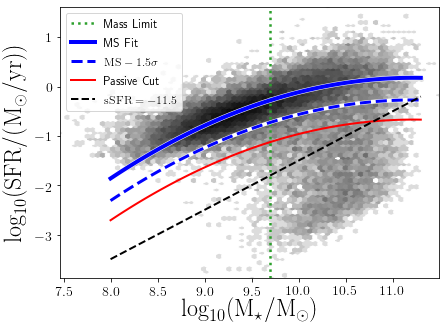

In [14]:
# plot main sequence
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 9.7 --ellip 0.75 --HIdef --minssfr -11.5
b.plot_full_ms()



# Using sample from paper

In [113]:
# plot main sequence
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 9.7 --ellip 0.75 --HIdef --minssfr -11.5



outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap.fits
number of lines in LCS cat =  2955
got sb flag
2759 2759 2759 2759
STD of pruned data = 0.18
STD of full data = 0.19
##################################
### FITTING WITH SIGMA CLIPPING 
##################################
Best-fit slope = 0.40
Best-fit inter = -4.16
Width of the MS = 0.19 (unclipped data)
###################################
### FITTING MS AFTER SIGMA CLIPPING 
###################################
Best-fit slope = 0.40+/-0.05
Best-fit inter = -4.16+/-0.54
percentile mass of field sample = 10.844


<Figure size 489.6x360 with 0 Axes>

SFR-Mstar best fit line :  [ -0.19689988   4.4186588  -24.60739556]
sqrt of cov matrix = , 3.073e-03, 1.230e+00, 3.061e+01
mean STD of MS = 0.29
median STD of MS = 0.29
average SFR of where gaussians overlap = -0.52
median SFR of where gaussians overlap = -0.52
mean offset from MS = -0.71
median offset from MS = -0.63
median Zscore of offset = -1.91


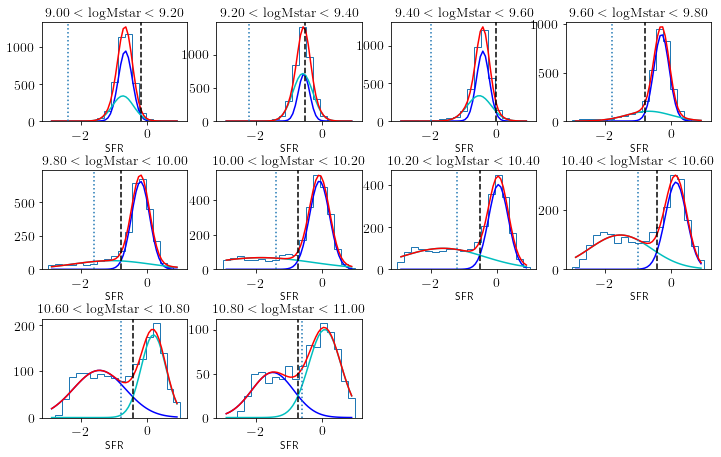

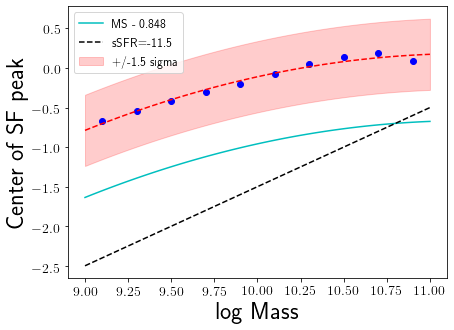

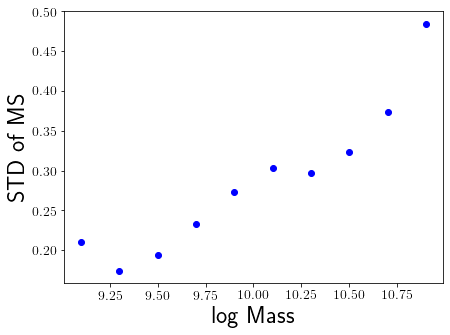

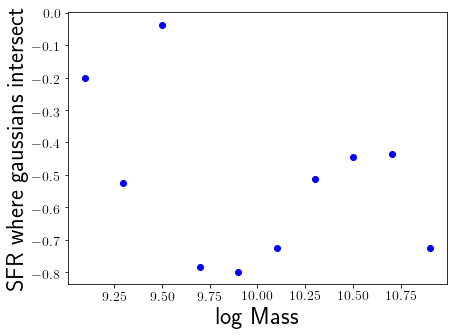

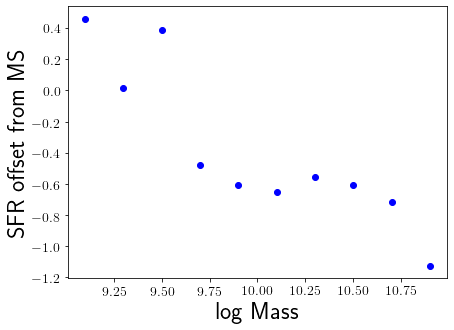

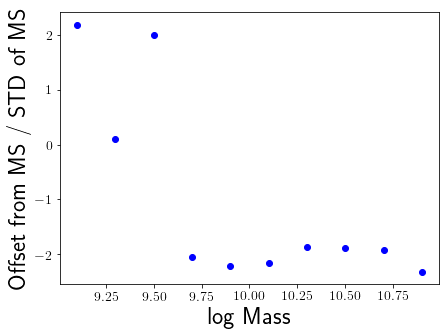

In [115]:
separate_sf(b.gsw.cat['logMstar'],b.gsw.cat['logSFR'],m1=9.,m2=11,ms_slope=0.592,ms_intercept=-6.05,dm=.2)

In [114]:
flag =   (b.gsw.cat['logMstar'] > 9.7) & (b.gsw.cat['logSFR']-b.gsw.cat['logMstar'] > -11.5)
logmstar = b.gsw.cat['logMstar'][flag]
from scipy.stats import scoreatpercentile
print("percentile mass of field sample = {:.3f}".format(scoreatpercentile(logmstar,95)))

percentile mass of field sample = 10.844


In [91]:
logmass = 10.8
yms = -.1968999*logmass**2+4.4186588*logmass-24.61
print('SFR at logmass = {:.3f}'.format(yms))
print("offset b/w MS and sSFR=-11.5 = {:.3f} ".format(yms- (logmass-11.5)))
print("offset relative to MS sigma = {:.3f}".format((yms- (logmass-11.5))/.3))

SFR at logmass = 0.145
offset b/w MS and sSFR=-11.5 = 0.845 
offset relative to MS sigma = 2.817


# Using sample from the paper, with B/T cut

SFR-Mstar best fit line :  [ -0.09348908   2.4324918  -15.1074248 ]
sqrt of cov matrix = , 4.140e-04, 1.657e-01, 4.124e+00
mean STD of MS = 0.27
median STD of MS = 0.27


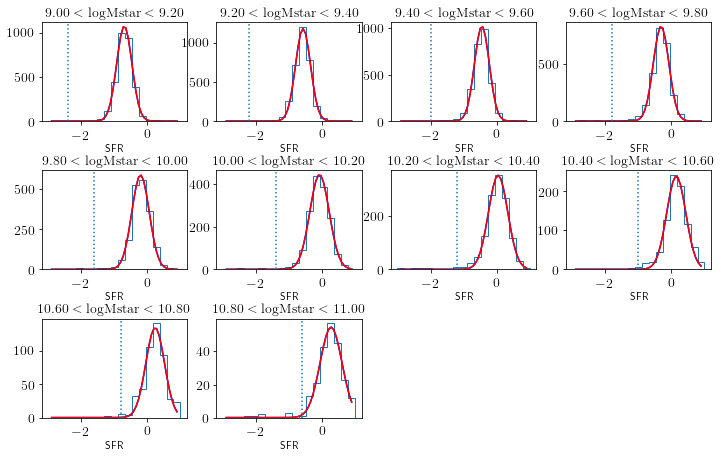

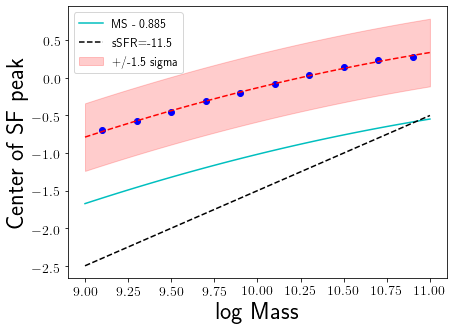

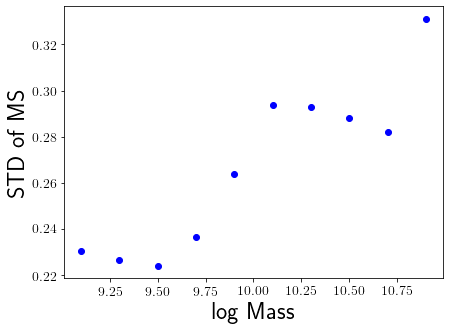

In [116]:
flag = b.gsw.cat['__B_T_r'] < 0.3
gswBTcut = b.gsw.cat[flag]
separate_sf(gswBTcut['logMstar'],gswBTcut['logSFR'],m1=9,m2=11,ms_slope=0.754,ms_intercept=-7.56,dm=.2,passive_cut=0.885,twogauss=False)

In [81]:
flag =   (gswBTcut['logMstar'] > 9.7) & (gswBTcut['logSFR']- gswBTcut['logMstar'] > -11.5)
logmstar = gswBTcut['logMstar'][flag]
from scipy.stats import scoreatpercentile
print("percentile mass of field sample = {:.3f}".format(scoreatpercentile(logmstar,98)))

percentile mass of field sample = 10.894


In [97]:
logmass = 10.8
yms = -0.1045*logmass**2+2.645*logmass-16.13
print("offset b/w MS and sSFR=-11.5 = {:.3f} ".format(yms- (logmass-11.5)))
print("offset relative to MS sigma = {:.3f}".format((yms- (logmass-11.5))/.3))

offset b/w MS and sSFR=-11.5 = 0.947 
offset relative to MS sigma = 3.157


# comparing MS with and without BT cut

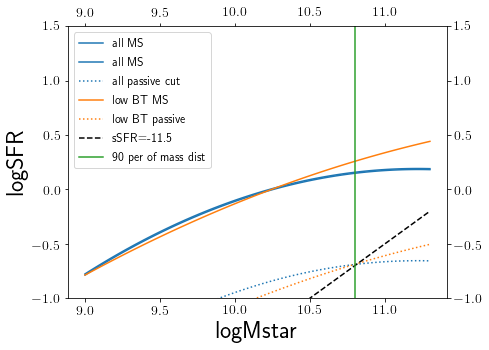

In [121]:
plt.figure()
xline = np.linspace(9,11.3,100)
yline = -0.1969*xline**2 +  4.4187*xline  -24.607
plt.plot(xline,yline,label='all MS',c=mycolors[0])
yline = -0.197*xline**2 +  4.42*xline  -24.6
plt.plot(xline,yline,label='all MS',c=mycolors[0])
#plt.plot(xline,yline-.45,label='all',ls='--')
plt.plot(xline,yline-.848,label='all passive cut',ls=':',c=mycolors[0])
# with BT cut
a,b,c = -0.09348908,   2.4324918,  -15.1074248
yline_lowBT = a*xline**2+b*xline+c 
plt.plot(xline,yline_lowBT,label='low BT MS',c=mycolors[1])
plt.plot(xline,yline_lowBT-.947,label='low BT passive',ls=':',c=mycolors[1])


plt.plot(xline,xline-11.5,ls='--',c='k',label='sSFR=-11.5')
plt.ylim(-1,1.5)
plt.axvline(x=10.8,label='90 per of mass dist',c=mycolors[2])

#plt.axvline(x=10.9)

#yline_lowBT_lomass8p5= 5.43557484e-04*xline**2 + 5.60202352e-01*xline -5.82658889e+00
#plt.plot(xline,yline_lowBT_lomass8p5,label='low mass cut 8.5')
plt.legend()
plt.xlabel('logMstar')
plt.ylabel('logSFR')
#plt.axhline(y=.145)
plt.gca().tick_params(right=True, top=True, labelright=True, labeltop=True)

# Using GSWLC, cut in redshift only

But we have already excluded a large part of the passive sequence because we have removed AGN.  What if we repeat the same procedure, but we use the full GSWLC, just limiting to the redshift range of the LCS.

In [13]:
gswlcs = Table.read(homedir+'/research/GSWLC/GSWLC-X2-LCS-Zoverlap.dat')

SFR-Mstar best fit line :  [ -0.12188612   2.91252827 -17.11201236]
sqrt of cov matrix = , 0.001, 0.283, 7.045
average SFR of where gaussians overlap = -0.56
median SFR of where gaussians overlap = -0.58
mean offset from MS = -0.64
median offset from MS = -0.64
mean STD of MS = 0.30
median STD of MS = 0.30
median Zscore of offset = -1.83


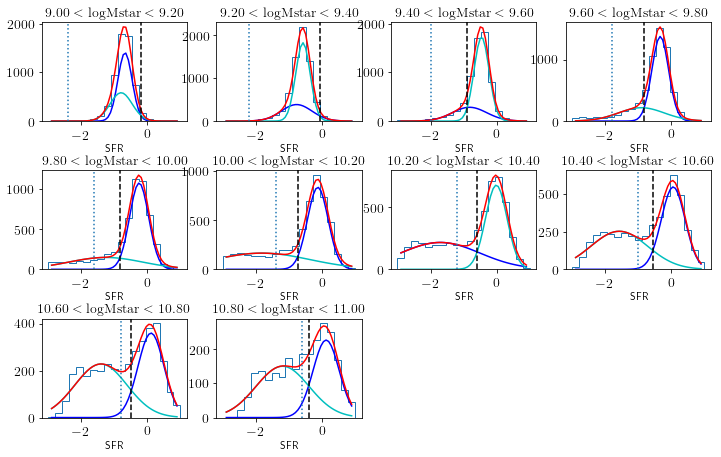

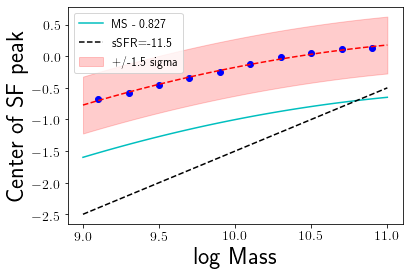

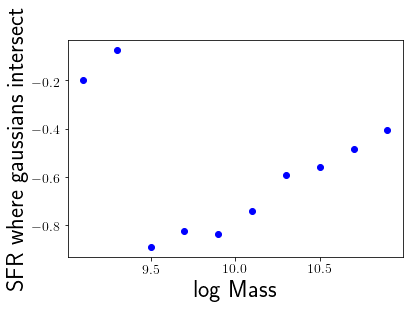

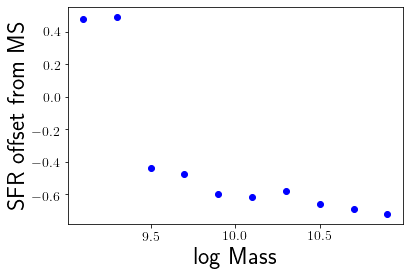

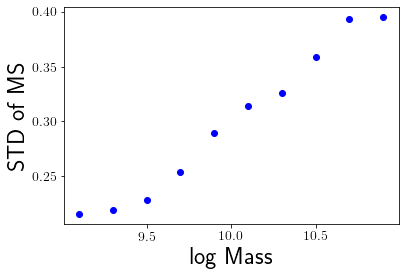

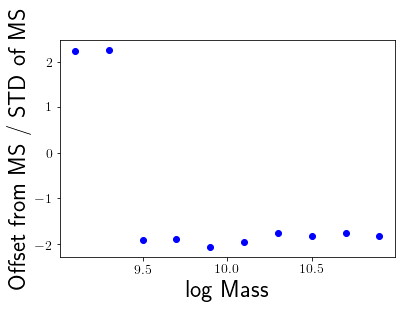

In [253]:
separate_sf(gswlcs['logMstar'],gswlcs['logSFR'],m1=9.,m2=11,ms_slope=.553,ms_intercept=-5.71,dm=.2)

In [262]:
logmass = 10.7
yms = -.121886*logmass**2+2.912528*logmass-17.1120
print("offset b/w MS and sSFR=-11.5 = {:.3f} ".format(yms- (logmass-11.5)))
print("offset relative to MS sigma = {:.3f}".format((yms- (logmass-11.5))/.3))

offset b/w MS and sSFR=-11.5 = 0.897 
offset relative to MS sigma = 2.991


In [250]:
10.**.827

6.714288529259523

In [251]:
.827-.45

0.37699999999999995

how to pick the mass where we define the offset relative to MS.  could use a percentile of LCS mass

In [260]:
lcsflag = (b.lcs.membflag | b.lcs.infallflag) & (b.lcs.cat['logMstar'] > 9.7) & (b.lcs.cat['logSFR']-b.lcs.cat['logMstar'] > -11.5)
logmstar = b.lcs.cat['logMstar'][lcsflag]
from scipy.stats import scoreatpercentile
print("percentile mass of LCS sample = {:.3f}".format(scoreatpercentile(logmstar,90)))

percentile mass of LCS sample = 10.652


In [261]:
flag =   (b.gsw.cat['logMstar'] > 9.7) & (b.gsw.cat['logSFR']-b.gsw.cat['logMstar'] > -11.5)
logmstar = b.gsw.cat['logMstar'][flag]
from scipy.stats import scoreatpercentile
print("percentile mass of field sample = {:.3f}".format(scoreatpercentile(logmstar,90)))

percentile mass of field sample = 10.707


In [241]:
.834-.45

0.38399999999999995

# Using full GSWLC

In [66]:
gsw = Table.read(homedir+'/research/GSWLC/GSWLC-X2.dat',format='ascii')

SFR-Mstar best fit line :  [ 0.7988648 -7.92889  ]
sqrt of cov matrix =  [0.03095352 0.30050428]
average SFR of where gaussians overlap = -0.57
median SFR of where gaussians overlap = -0.57
mean offset from MS = -0.92
median offset from MS = -0.86
mean STD of MS = 0.37
median STD of MS = 0.31
median Zscore of offset = -2.05


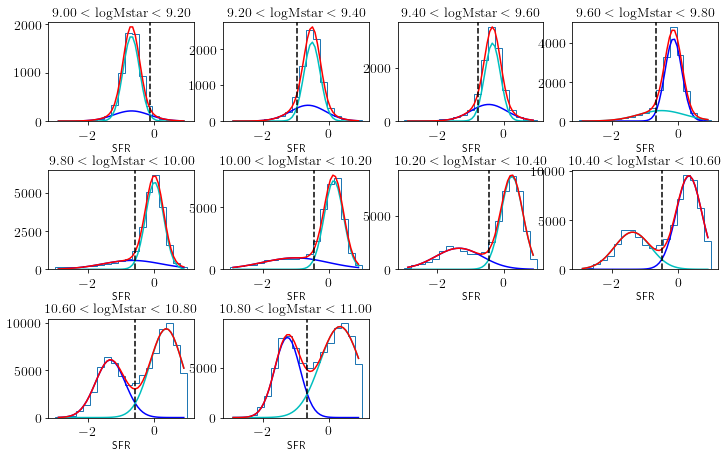

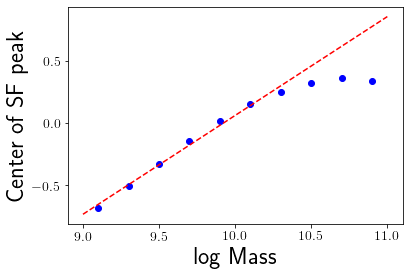

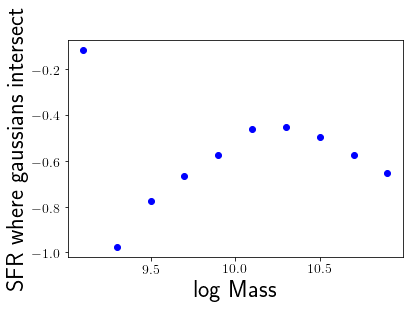

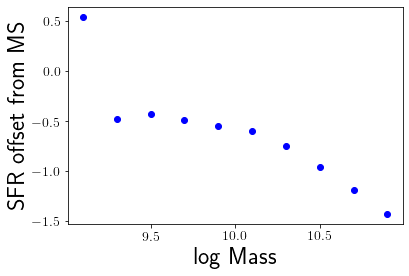

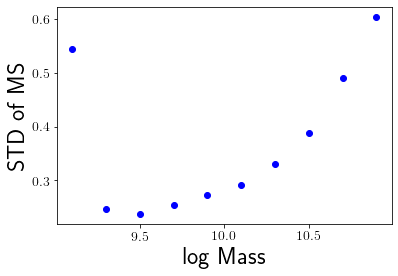

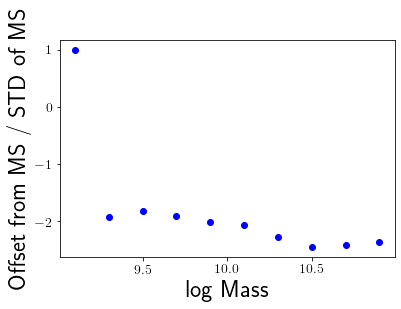

In [159]:
separate_sf(gsw['logMstar'],gsw['logSFR'],m1=9,m2=11,ms_slope=.799,ms_intercept=-7.93,dm=.2)

# Summary of fits

Text(0, 0.5, 'logSFR')

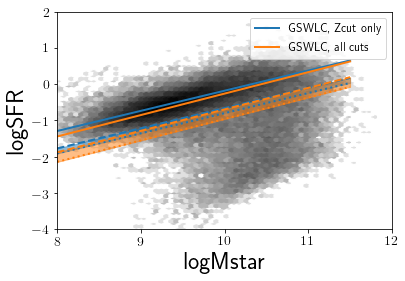

In [161]:
mycolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure()
plt.hexbin(gswlcs['logMstar'],gswlcs['logSFR'],cmap='gray_r',gridsize=75,bins='log')
xline = np.linspace(8,11.5,100)
# from GSWLC with LCS z cut
yline = .556*xline-5.74
STD = 0.32
offset = -0.62
plt.plot(xline,yline,lw=2,c=mycolors[0],label='GSWLC, Zcut only')
plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[0])
plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[0])
plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[0],alpha=.5)

# from GSWLC, cut according to AGC, Simard, etc
STD = 0.29
offset = -0.7
yline = 0.592*xline -6.18
plt.plot(xline,yline,lw=2,c=mycolors[1],label='GSWLC, all cuts')
plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[1])
plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[1])
plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[1],alpha=.5)
plt.legend()


# from full GSWLC
STD = 0.3
offset = -0.82
yline = 0.799*xline -7.92
#plt.plot(xline,yline,lw=2,c=mycolors[2],label='GSWLC')
#plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[2])
#plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[2])
#plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[2],alpha=.5)
plt.legend()
plt.axis([8,12,-4,2])
plt.xlabel('logMstar')
plt.ylabel('logSFR')

No handles with labels found to put in legend.


[8, 12, -4, 2]

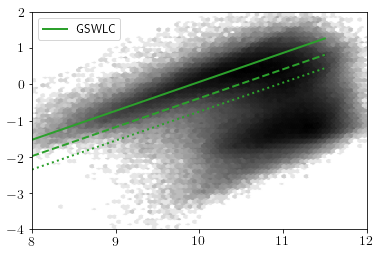

In [157]:
mycolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure()
plt.hexbin(gsw['logMstar'],gsw['logSFR'],cmap='gray_r',gridsize=75,bins='log',extent=(8,12,-4,2))
xline = np.linspace(8,11.5,100)
# from GSWLC with LCS z cut
yline = .556*xline-5.74
STD = 0.32
offset = -0.62
#plt.plot(xline,yline,lw=2,c=mycolors[0],label='GSWLC, Zcut only')
#plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[0])
#plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[0])
#plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[0],alpha=.5)

# from GSWLC, cut according to AGC, Simard, etc
STD = 0.29
offset = -0.7
yline = 0.592*xline -6.18
#plt.plot(xline,yline,lw=2,c=mycolors[1],label='GSWLC, all cuts')
#plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[1])
#plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[1])
#plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[1],alpha=.5)
plt.legend()


# from full GSWLC
STD = 0.3
offset = -0.82
yline = 0.799*xline -7.92
plt.plot(xline,yline,lw=2,c=mycolors[2],label='GSWLC')
plt.plot(xline,yline-1.5*STD,ls='--',lw=2,c=mycolors[2])
plt.plot(xline,yline+offset,ls=':',lw=2,c=mycolors[2])
#plt.fill_between(xline,yline-1.5*STD,yline+offset,color=mycolors[2],alpha=.5)
plt.legend()
plt.axis([8,12,-4,2])

SFR-Mstar best fit line :  [ 0.84040107 -8.57044881]
sqrt of cov matrix =  [0.17484143 1.70619768]
average SFR of where gaussians overlap = -0.66
median SFR of where gaussians overlap = -0.55
mean offset from MS = -0.83
median offset from MS = -0.63
mean STD of MS = 0.43
median STD of MS = 0.28
median Zscore of offset = -1.26


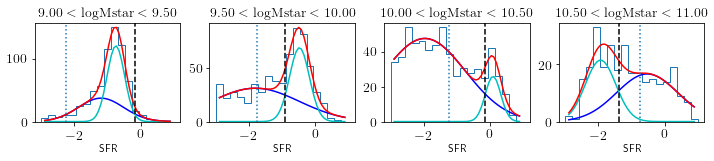

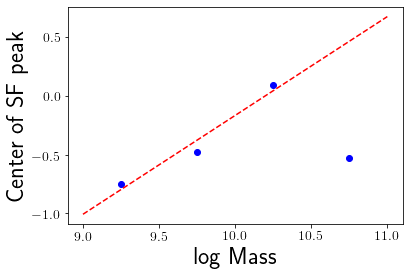

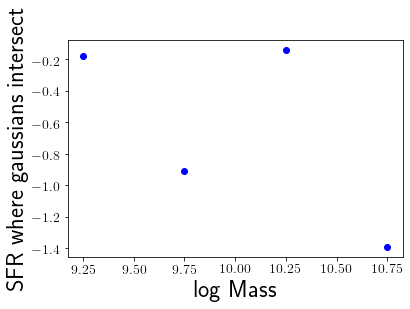

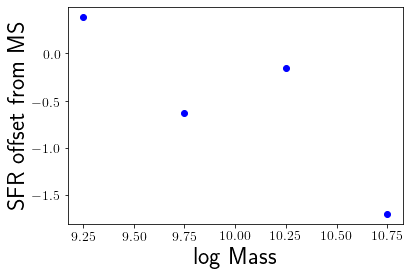

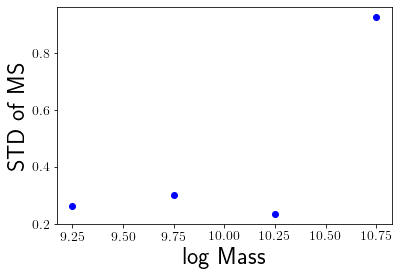

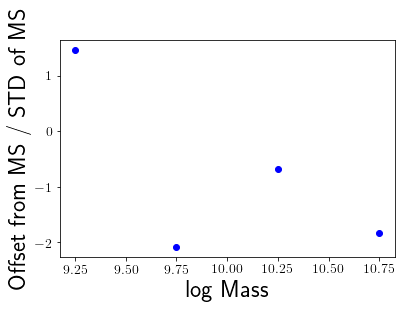

In [171]:
separate_sf(b.lcs.cat['logMstar'],b.lcs.cat['logSFR'],m1=9.,m2=11,ms_slope=0.592,ms_intercept=-6.05,dm=.5)

SFR-Mstar best fit line :  [ -0.05765684   1.81899459 -12.63361194]
sqrt of cov matrix = , 2.468e-02, 9.876e+00, 2.457e+02
mean STD of MS = 0.23
median STD of MS = 0.25
average SFR of where gaussians overlap = -0.43
median SFR of where gaussians overlap = -0.42
mean offset from MS = -0.65
median offset from MS = -0.77
median Zscore of offset = -2.59


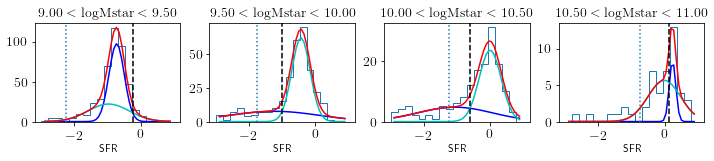

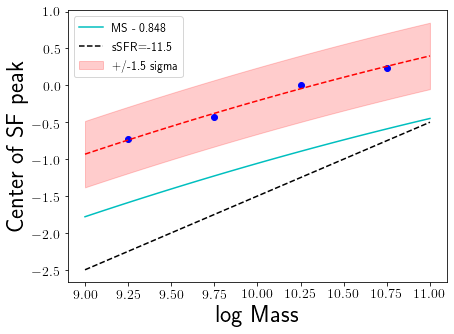

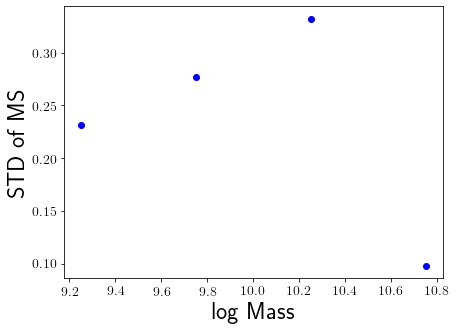

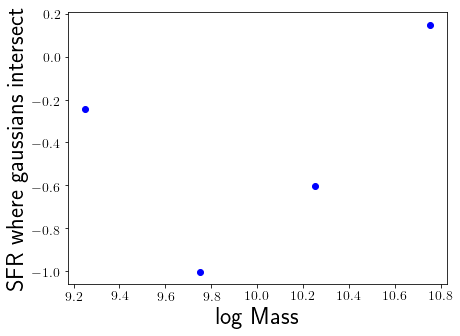

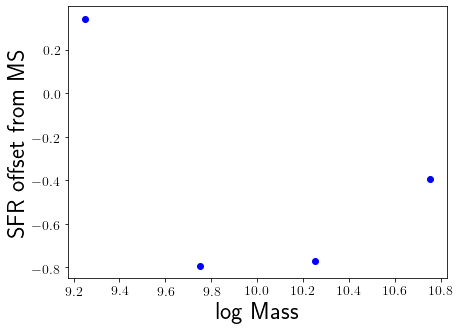

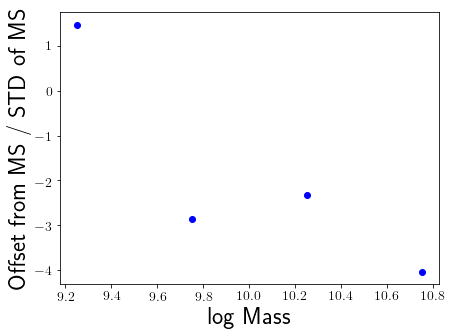

In [126]:
flag = (b.lcs.cat['__B_T_r'] < 0.3) & (b.lcs.membflag | b.lcs.infallflag)
lcsBTcut = b.lcs.cat[flag]
separate_sf(lcsBTcut['logMstar'],lcsBTcut['logSFR'],m1=9.,m2=11,ms_slope=0.754,ms_intercept=-7.56,dm=.5)

# Discussion

* looking at passive vs SF peaks in field and cluster

In [123]:
# plot main sequence
os.chdir(homedir+'/research/LCS/plots/')
%run ~/github/LCS/python/lcs_paper2_v2.py  --minmass 9.7 --ellip 0.75 --HIdef --minssfr -11.5


outfile =  /home/rfinn/research/GSWLC/GSWLC-X2-NO-DR10-AGN-Simard2011-tab1-tab3-Tempel-13-2021Jan07-LCS-Zoverlap.fits
number of lines in LCS cat =  2955
got sb flag
2759 2759 2759 2759
STD of pruned data = 0.18
STD of full data = 0.19
##################################
### FITTING WITH SIGMA CLIPPING 
##################################
Best-fit slope = 0.40
Best-fit inter = -4.16
Width of the MS = 0.19 (unclipped data)
###################################
### FITTING MS AFTER SIGMA CLIPPING 
###################################
Best-fit slope = 0.40+/-0.05
Best-fit inter = -4.16+/-0.54


<Figure size 489.6x360 with 0 Axes>

SFR-Mstar best fit line :  [ -0.09348908   2.4324918  -15.1074248 ]
sqrt of cov matrix = , 4.140e-04, 1.657e-01, 4.124e+00
mean STD of MS = 0.27
median STD of MS = 0.27


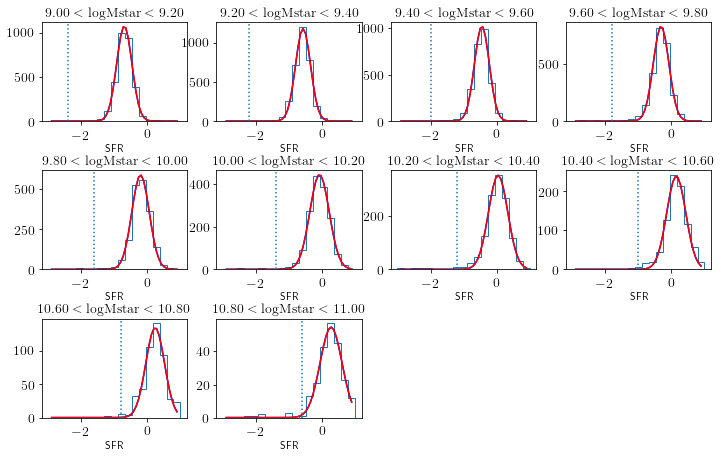

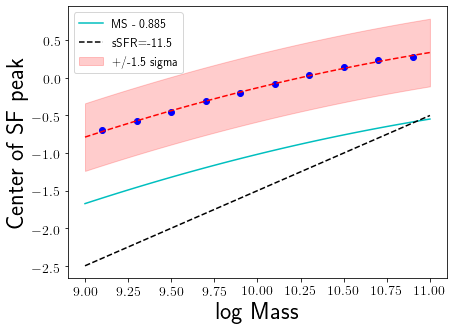

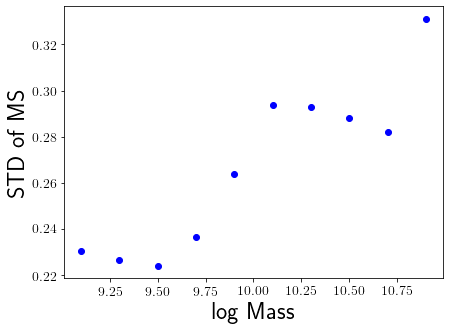

In [124]:
flag = b.gsw.cat['__B_T_r'] < 0.3
gswBTcut = b.gsw.cat[flag]
separate_sf(gswBTcut['logMstar'],gswBTcut['logSFR'],m1=9,m2=11,ms_slope=0.754,ms_intercept=-7.56,dm=.2,passive_cut=0.885,twogauss=False)

SFR-Mstar best fit line :  [ -0.23547696   5.26677435 -29.30554284]
sqrt of cov matrix = , 1.043e-02, 4.176e+00, 1.039e+02
mean STD of MS = 0.39
median STD of MS = 0.32


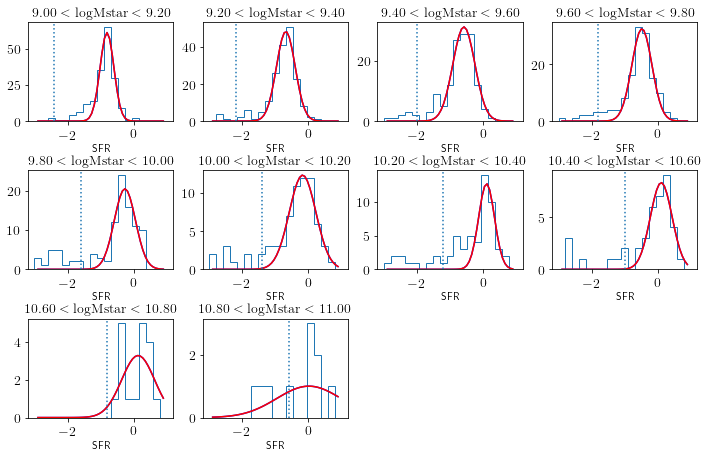

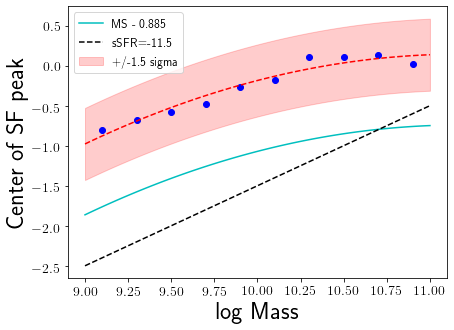

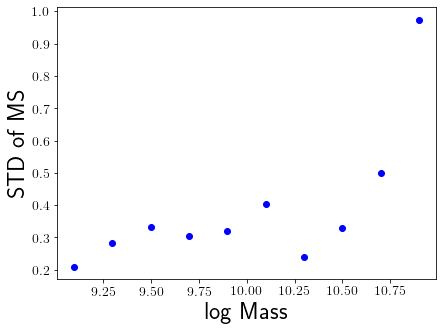

In [125]:
flag = b.lcs.cat['__B_T_r'] < 0.3
lcsBTcut = b.lcs.cat[flag]
separate_sf(lcsBTcut['logMstar'],lcsBTcut['logSFR'],m1=9,m2=11,ms_slope=0.754,ms_intercept=-7.56,dm=.2,passive_cut=0.885,twogauss=False)